## TEXT DETECTION

In [7]:
# import modules
%matplotlib inline
import random
import pylab
import pandas as pd
import numpy as np
import cPickle as pkl
from PIL import Image
import matplotlib.pyplot as plt
from lasagne import layers
from lasagne.updates import nesterov_momentum
from theano.tensor.nnet import softmax
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import BatchIterator

In [8]:
from scipy.misc import imread as ims
img = ims('/home/faizy/workspace/project/project/datasets/svt/svt1/img/01_15.jpg')
img.shape

(800, 1280, 3)

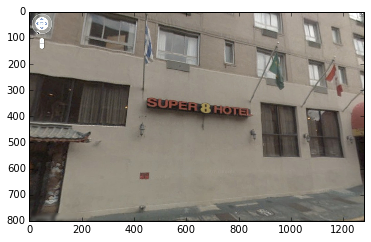

In [9]:
pylab.imshow(img)
pylab.show()

In [10]:
lst = []
for i in range(0, 800, 50):
    for j in range(0, 1280, 60):
        if not (i + 50 > 800 or j + 60 > 1280):
            lst.append(img[i:i+50, j:j+60, :])

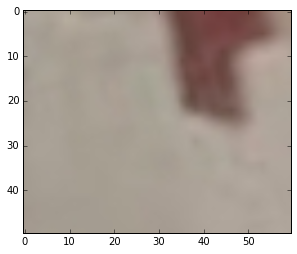

In [11]:
i = random.randrange(0, 336)
pylab.imshow(lst[i])

In [12]:
from scipy.misc import imresize
new_lst = []
for i in lst:
    new_lst.append(imresize(i, (28, 28)))

In [13]:
new_list = np.stack(new_lst)
new_list = new_list.dot([0.299, 0.587, 0.144])
new_list.shape
tester = new_list.reshape(336, 1, 28, 28)

In [14]:
tester /= tester.std(axis = None)
tester -= tester.mean()
tester = tester.astype('float32')

In [ ]:
#TODO implement a chars74k trained network
preder = net.predict(tester)